## Importing Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import spacy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

## Reading the data

In [2]:
# Give the full path
path = "C:\\Users\\kyria\\OneDrive\\Υπολογιστής\\Statistics And Machine Learning\\Text Mining\\Text-Mining-Project\\Data\\fake_job_postings.csv"
data = pd.read_csv(path)
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Learning about the data

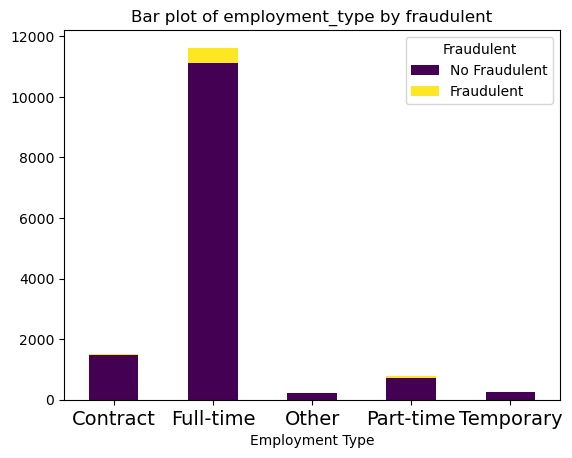

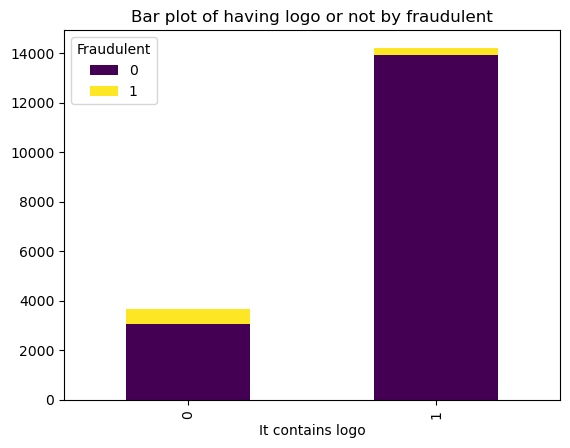

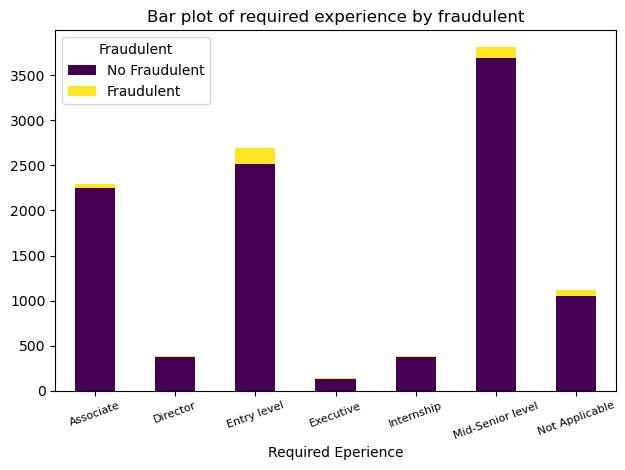

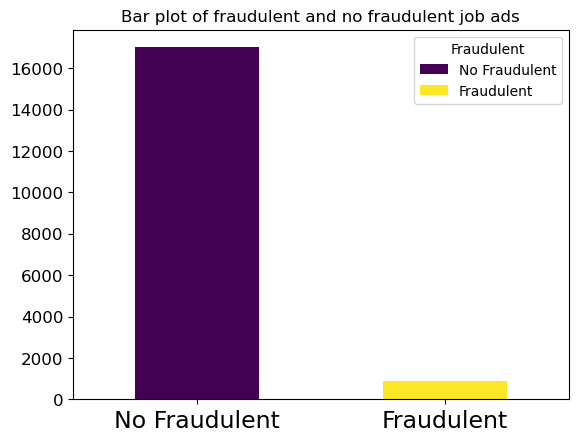

In [63]:
employment_by_fraudulent = data.groupby(['employment_type', 'fraudulent']).size().unstack()
has_company_logo_by_fraudulent = data.groupby(['has_company_logo', 'fraudulent']).size().unstack()
required_experience_by_fraudulent = data.groupby(['required_experience', 'fraudulent']).size().unstack()
fraudulent_counts = data.groupby(['fraudulent', 'fraudulent']).size().unstack()

# For emploment type
employment_by_fraudulent.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Bar plot of employment_type by fraudulent')
plt.xlabel('Employment Type')
plt.xticks(rotation=0, fontsize=14)
plt.legend(title='Fraudulent', loc='upper right', labels = ["No Fraudulent", 'Fraudulent'])
plt.savefig("employment_distribution.png")
plt.show()

# For either containing logo or not
has_company_logo_by_fraudulent.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Bar plot of having logo or not by fraudulent')
plt.xlabel('It contains logo')
plt.legend(title='Fraudulent', loc='upper left')
plt.show()

# For different working sectors
required_experience_by_fraudulent.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Bar plot of required experience by fraudulent')
plt.xlabel('Required Eperience')
plt.legend(title='Fraudulent', loc='upper left', labels = ["No Fraudulent", 'Fraudulent'])
plt.tick_params(axis='x', which='major', labelsize=10)
plt.xticks(rotation=20, fontsize=8)
plt.savefig("working_sectors.png")
plt.tight_layout()
plt.show()

# The number of fraudelent and not fradulent job ads
fraudulent_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Bar plot of fraudulent and no fraudulent job ads')
plt.xlabel('')
#plt.ylabel('Number of occurences', fontsize=15)
plt.legend(title='Fraudulent', loc='upper right', labels = ["No Fraudulent", 'Fraudulent'])
plt.tick_params(axis='x', which='major', labelsize=10)
plt.xticks(rotation=0, labels=["No Fraudulent", "Fraudulent"], ticks=[0,1], fontsize=17)
plt.yticks(fontsize=12)
plt.savefig("data_distribution.png")
plt.show()


From the above plots we can extract some insights regarding the dataset. We can see that the vast majority of the fraudulent job ads are for full time job. That's reasonable as most of the job seekers look for a full time job. In the second plot, it's easily observable that most of the pretending companies don't have a logo. So that's an important factor of classifying if a job ad is fraudulent or not. In respect of the third plot, no fake job ad asks for high position (such as director) but mostly for the entry-mid level jobs. The dataset is heavily imbalanced as can be observed at the last plot. The real job ads are roundly 16 times more than the fradulent job ads. A approach that we could deal with the imbalanced dataset is oversampling which we will come to the later. 

## Making bags of words for more insights of the data

#### Write the tokenization function

In [3]:
# Taken from lab 1
# Perform lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
def preprocess(text):
    """Preprocess the given text by tokenising it, removing any stop words, 
    replacing each remaining token with its lemma (base form), and discarding 
    all lemmas that contain non-alphabetical characters.

    Arguments:
      text (str): The text to preprocess.

    Returns:
      The list of remaining lemmas after preprocessing (represented as strings).
    """

    # Tokenisation
    words = nlp(text)
    # Stop word removal
    words = [token for token in words if not token.is_stop and token.is_alpha]
    # Lemmatisation
    words  = [token.lemma_ for token in words]

    return(words)

#### Write a function to fit a vectorizer given text data

In [4]:
def make_a_vectorizer(documents, preprocess):
    """Fits and transforms a vectorizer on a series of documents containing text.  
      
    Arguments:
      documents (str): A series of texts
      preprocess (function): A function that performs tokenization before the count vectorizer takes place

    Returns:
      An array containing all the number of occurence of every word in every document
      A vectorizer object that it has been fitted to the given text
    """
    # Making a bag of words for the no fraudulent job descriptions
    vectorizer = CountVectorizer(tokenizer=preprocess)

    # fit the vocabulary to the text data and create the bag-of-words model 
    X = vectorizer.fit_transform(documents)

    return(X, vectorizer)

#### Write a function that returns a bag of n words

In [5]:
def make_bag_of_words(X, vectorizer, n):
    """ It finds the n most common words of a count vectorizer

    Arguments:
      vectorizer: An object of type vectorizer which is already fitted and transformed on some text
      X: An array containing all the number of occurence of every word in every document
      n: The number of the most frequent words that it will return

      Returns: A pandas series containing the n most frequent words
    """

    feature_names = vectorizer.get_feature_names_out()

    # Convert the bag of words into a DataFrame 
    bow_df = pd.DataFrame(X.toarray(), columns=feature_names)
    word_frequencies = bow_df.sum(axis=0) 
    top_n_words = word_frequencies.nlargest(n) # Get the n most frequent words
    return(top_n_words)
    

#### Splitting up the description into fraudulent and non draudulent

In [6]:
# Splitting up the descriptions based on if they are fraudulent or not
mask = data['fraudulent'] == 0 # Create a mask for seperating the real and the fake job ads
no_fraudulent_descriptions = data[mask]["description"]
fraudulent_descriptions = data[~mask]["description"]


#### For the non fraudulent descriptions

In [30]:
# Create the vectorizer for 
X_no_fraud, no_fraud_vectorizer = make_a_vectorizer(no_fraudulent_descriptions, preprocess)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [34]:
n = 10 # Define the desirable number of the most common words
print(make_bag_of_words(X_no_fraud, no_fraud_vectorizer, n))

team          19671
work          19584
customer      14367
service       12002
business      11109
company       11083
client        11002
product       10993
experience    10353
new            9474
dtype: int64


#### For the fraudulent descriptions

In [36]:
X_fraud, fraud_vectorizer = make_a_vectorizer(fraudulent_descriptions.values.astype('U'), preprocess) # To avoid the error

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [64]:
print(make_bag_of_words(X_fraud, fraud_vectorizer, n))

work        1167
service      763
customer     680
project      607
amp          596
product      591
position     578
team         552
company      550
time         504
dtype: int64


We can easily see that the dataset is exteremely imbalanced and the fraudulent descriptions are very similar and difficult to distinguish them according the 2 above bags of words. We will try different classifiers without oversampling/undersampling and we will define them as baselines, for each model. We will try to investigate if different methods of oversampling/undersampling will improve the performance. As metric we will have ROC score as we deal with a binary classification problem.

#### Splitting the dataset into training and test sets

In [7]:
X = data.drop('fraudulent', axis=1)
y = data['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% of training data and 20% testing data

#### Make a vectorizer that will use lemmatization according to the training data

In [8]:
_, training_vectorizer = make_a_vectorizer(X_train['description'].values.astype('U'), preprocess)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### A function that plots the ROC curve of a classifier and the ROC score

In [9]:
def plot_roc(ground_truth_values, predictions, classifier_name):
    """ It plots the ROC curve with the ROC score of a classifier on data

    Arguments:
      ground_truth_values: The real values of the given data that we will predict
      predictions: The predictions that were made by a classifier
      classifier_name: The name that will be used on the plot for the classifier
      
      Returns: 
    """
    
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_values, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=classifier_name)
    display.plot()
    plt.show()
    

## Defining the baseline models

#### Naive Bayes Classifier

In [42]:
# Import the function
from sklearn.naive_bayes import BernoulliNB

# Define the pipeline
pipe = Pipeline([('vectorize', training_vectorizer), 
                 ('clf', BernoulliNB())])
# Train the pipeline
pipe.fit(X_train['description'].values.astype('U'), y_train)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 CountVectorizer(tokenizer=<function preprocess at 0x00000178110C98A0>)),
                ('clf', BernoulliNB())])

In [57]:
naive_baseline_pred = pipe.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, naive_baseline_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3395
           1       0.74      0.18      0.29       181

    accuracy                           0.96      3576
   macro avg       0.85      0.59      0.63      3576
weighted avg       0.95      0.96      0.94      3576



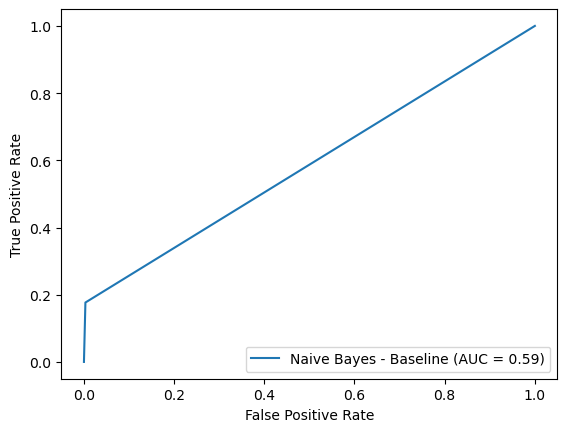

In [58]:
# Get the roc score and plot the roc curve
plot_roc(y_test, naive_baseline_pred, "Naive Bayes - Baseline")

#### Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipe = Pipeline([('vectorize', training_vectorizer), 
                 ('clf', LogisticRegression(max_iter=150))]) # The default is 100. With 100 iterations we didn't reach to convergence.
# Train the pipeline
pipe.fit(X_train['description'].values.astype('U'), y_train)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 CountVectorizer(tokenizer=<function preprocess at 0x00000178110C98A0>)),
                ('clf', LogisticRegression(max_iter=150))])

In [67]:
logreg_baseline_pred = pipe.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, logreg_baseline_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.83      0.60      0.70       181

    accuracy                           0.97      3576
   macro avg       0.91      0.80      0.84      3576
weighted avg       0.97      0.97      0.97      3576



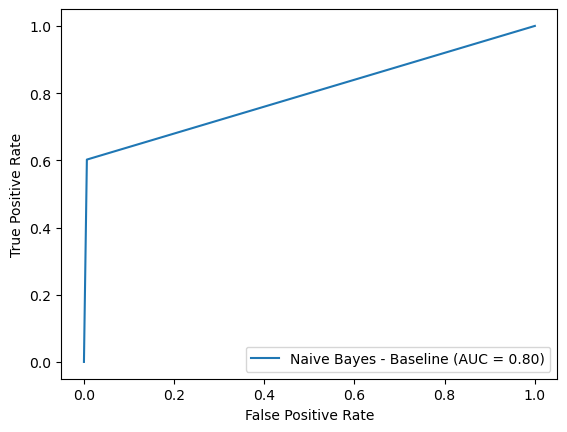

In [68]:
# Get the roc score and plot the roc curve
plot_roc(y_test, logreg_baseline_pred, "Naive Bayes - Baseline")

#### Decision Trees

In [69]:
from sklearn import tree

# Define the pipeline
pipe = Pipeline([('vectorize', training_vectorizer), 
                 ('clf', tree.DecisionTreeClassifier())]) # The default is 100. With 100 iterations we didn't reach to convergence.
# Train the pipeline
pipe.fit(X_train['description'].values.astype('U'), y_train)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 CountVectorizer(tokenizer=<function preprocess at 0x00000178110C98A0>)),
                ('clf', DecisionTreeClassifier())])

In [70]:
dectrees_baseline_pred = pipe.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, dectrees_baseline_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3395
           1       0.77      0.62      0.69       181

    accuracy                           0.97      3576
   macro avg       0.87      0.80      0.83      3576
weighted avg       0.97      0.97      0.97      3576



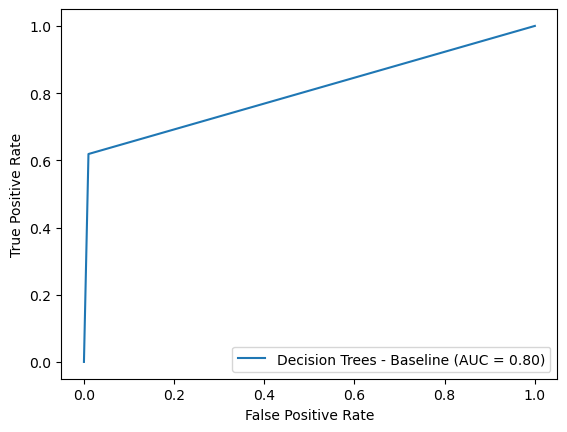

In [73]:
# Get the roc score and plot the roc curve
plot_roc(y_test, dectrees_baseline_pred, "Decision Trees - Baseline")

#### Support Vector Machine

In [11]:
from sklearn.svm import LinearSVC

# Define the pipeline
pipe = Pipeline([('vectorize', training_vectorizer), 
                 ('clf', LinearSVC())]) 
# Train the pipeline
pipe.fit(X_train['description'].values.astype('U'), y_train)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('vectorize',
                 CountVectorizer(tokenizer=<function preprocess at 0x000002AAB507CF40>)),
                ('clf', LinearSVC())])

In [12]:
svm_baseline_pred = pipe.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, svm_baseline_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.76      0.64      0.69       181

    accuracy                           0.97      3576
   macro avg       0.87      0.81      0.84      3576
weighted avg       0.97      0.97      0.97      3576



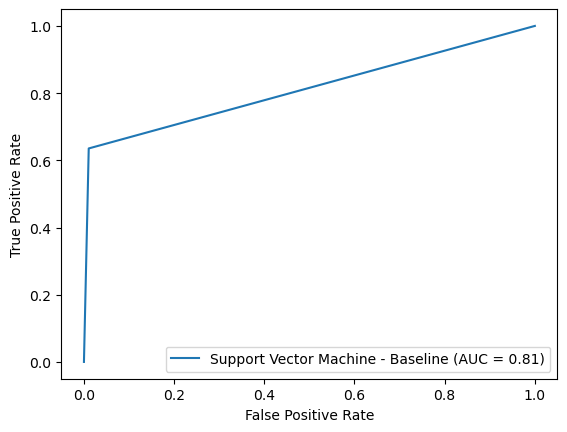

In [14]:
# Get the roc score and plot the roc curve
plot_roc(y_test, svm_baseline_pred, "Support Vector Machine - Baseline")

## Oversampling/Undersampling techniques

We have to convert the descriptions on the raw text before we use the oversampling/undersampling techniques

In [16]:
X_test = training_vectorizer.transform(X_test['description'].values.astype('U'))
X_train = training_vectorizer.transform(X_train['description'].values.astype('U'))

### SMOTE

In [17]:
# Oversampling the dataset with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

# Printing the number of samples of each class
print("The total number of fraudulent job ads are ", sum(y_smote_train == 1))
print("The total number of no fraudulent job ads are ", sum(y_smote_train == 0))

The total number of fraudulent job ads are  13619
The total number of no fraudulent job ads are  13619


#### Naive Bayes Classifier

In [13]:
# Define the pipeline
pipe = Pipeline([('clf', BernoulliNB())]) # We remove the vectorizer as the vectorizer has already been perfomed above
# Train the pipeline
pipe.fit(X_smote_train, y_smote_train)

Pipeline(steps=[('clf', BernoulliNB())])

In [14]:
naive_smote_pred = pipe.predict(X_test)
print(classification_report(y_test, naive_smote_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3395
           1       0.19      0.65      0.29       181

    accuracy                           0.84      3576
   macro avg       0.58      0.75      0.60      3576
weighted avg       0.94      0.84      0.88      3576



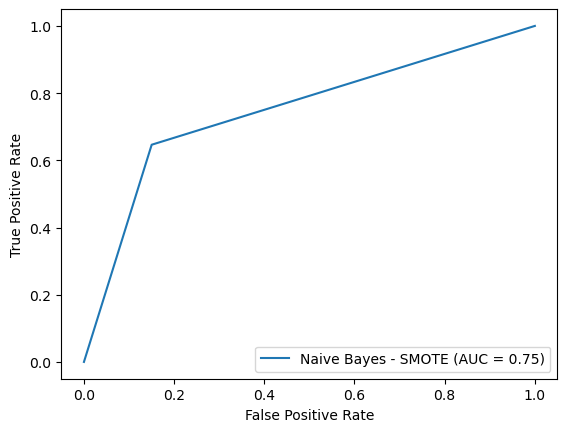

In [15]:
plot_roc(y_test, naive_smote_pred, "Naive Bayes - SMOTE")

#### Logistic Regression

In [16]:
# Define the pipeline
pipe = Pipeline([('clf', LogisticRegression(max_iter=200))]) # The default is 100. With 100 iterations we didn't reach to convergence.
# Train the pipeline
pipe.fit(X_smote_train, y_smote_train)

Pipeline(steps=[('clf', LogisticRegression(max_iter=200))])

In [18]:
logreg_smote_pred = pipe.predict(X_test)
print(classification_report(y_test, logreg_smote_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3395
           1       0.46      0.70      0.56       181

    accuracy                           0.94      3576
   macro avg       0.72      0.83      0.76      3576
weighted avg       0.96      0.94      0.95      3576



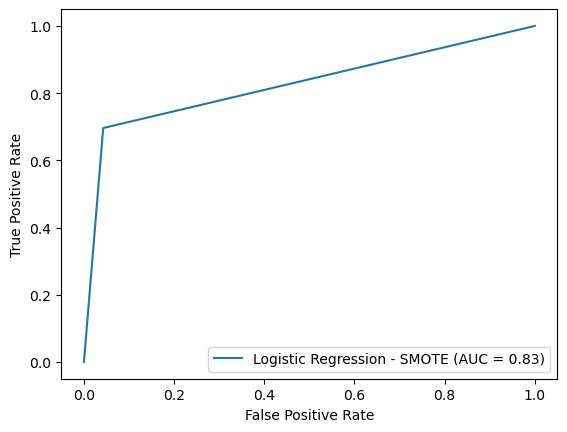

In [19]:
plot_roc(y_test, logreg_smote_pred, "Logistic Regression - SMOTE")

 #### Decision Trees

In [26]:
# Define the pipeline
pipe = Pipeline([('clf', tree.DecisionTreeClassifier())])
# Train the pipeline
pipe.fit(X_smote_train, y_smote_train)

Pipeline(steps=[('clf', DecisionTreeClassifier())])

In [28]:
dectrees_smote_pred = pipe.predict(X_test)
print(classification_report(y_test, dectrees_smote_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3395
           1       0.40      0.67      0.50       181

    accuracy                           0.93      3576
   macro avg       0.69      0.81      0.73      3576
weighted avg       0.95      0.93      0.94      3576



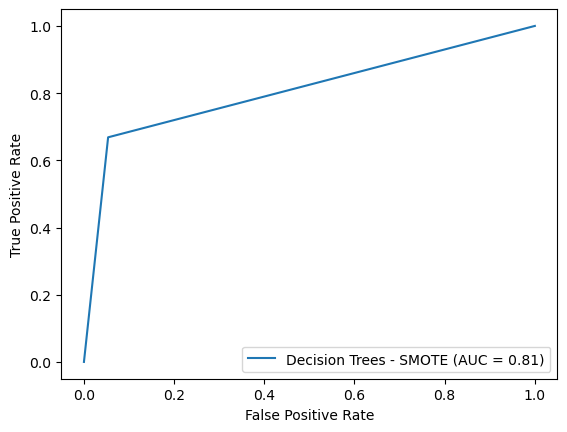

In [29]:
plot_roc(y_test, dectrees_smote_pred, "Decision Trees - SMOTE")

#### Support Vector Machine

In [18]:
# Define the pipeline
pipe = Pipeline([ ('clf', LinearSVC())]) 
# Train the pipeline
pipe.fit(X_train, y_train)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('clf', LinearSVC())])

In [19]:
svm_smote_pred = pipe.predict(X_test)
print(classification_report(y_test, svm_smote_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.76      0.64      0.69       181

    accuracy                           0.97      3576
   macro avg       0.87      0.81      0.84      3576
weighted avg       0.97      0.97      0.97      3576



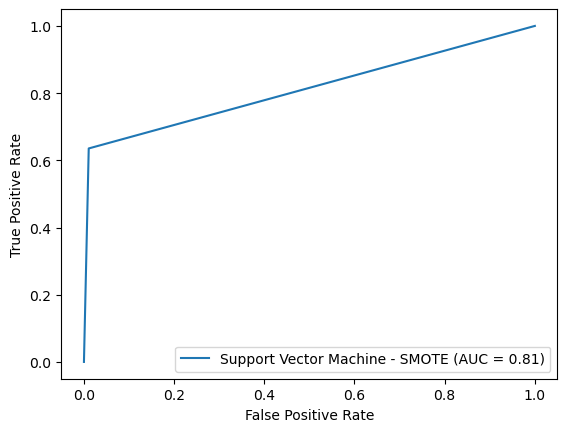

In [20]:
plot_roc(y_test, svm_smote_pred, "Support Vector Machine - SMOTE")

### NearMiss

In [22]:
# Undersampling the dataset with NearMiss
from imblearn.under_sampling import NearMiss
near_miss = NearMiss()
X_ns_train, y_ns_train = near_miss.fit_resample(X_train, y_train)

# Printing the number of samples of each class
print("The total number of fraudulent job ads are ", sum(y_ns_train == 1))
print("The total number of no fraudulent job ads are ", sum(y_ns_train == 0))

The total number of fraudulent job ads are  685
The total number of no fraudulent job ads are  685


#### Naive Bayes Classifier

In [37]:
# Define the pipeline
pipe = Pipeline([('clf', BernoulliNB())]) # We remove the vectorizer as the vectorizer has already been perfomed above
# Train the pipeline
pipe.fit(X_ns_train, y_ns_train)

Pipeline(steps=[('clf', BernoulliNB())])

In [41]:
naive_ns_pred = pipe.predict(X_test)
print(classification_report(y_test, naive_ns_pred))

              precision    recall  f1-score   support

           0       0.96      0.24      0.38      3395
           1       0.05      0.82      0.10       181

    accuracy                           0.27      3576
   macro avg       0.51      0.53      0.24      3576
weighted avg       0.91      0.27      0.37      3576



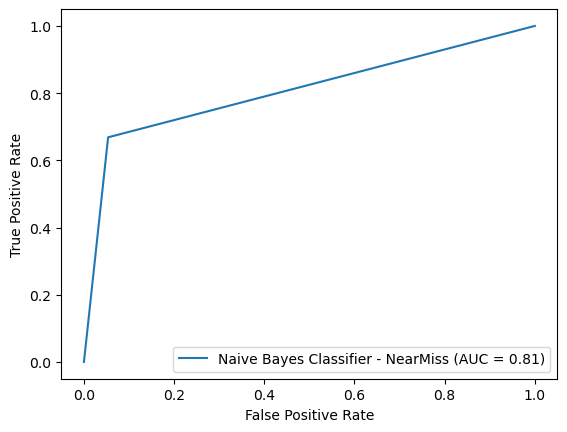

In [39]:
plot_roc(y_test, dectrees_smote_pred, "Naive Bayes Classifier - NearMiss")

#### Logistic Regression

In [55]:
# Define the pipeline
pipe = Pipeline([('clf', LogisticRegression(max_iter=200))]) # The default is 100. With 100 iterations we didn't reach to convergence.
# Train the pipeline
pipe.fit(X_ns_train, y_ns_train)

Pipeline(steps=[('clf', LogisticRegression(max_iter=200))])

In [56]:
logreg_ns_pred = pipe.predict(X_test)
print(classification_report(y_test, logreg_ns_pred))

              precision    recall  f1-score   support

           0       0.98      0.22      0.36      3395
           1       0.06      0.92      0.11       181

    accuracy                           0.26      3576
   macro avg       0.52      0.57      0.24      3576
weighted avg       0.94      0.26      0.35      3576



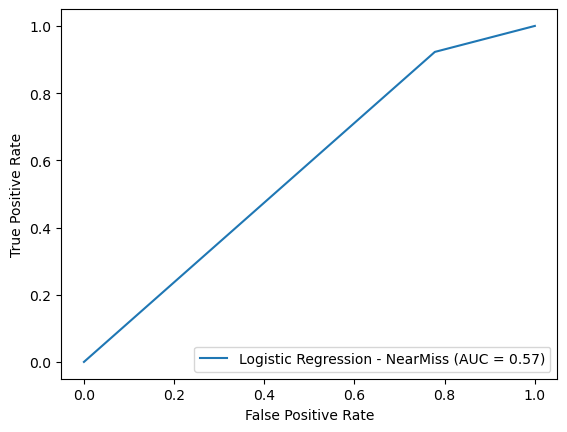

In [57]:
plot_roc(y_test, logreg_ns_pred, "Logistic Regression - NearMiss")

#### Decision Trees

In [58]:
# Define the pipeline
pipe = Pipeline([('clf', tree.DecisionTreeClassifier())])
# Train the pipeline
pipe.fit(X_ns_train, y_ns_train)

Pipeline(steps=[('clf', DecisionTreeClassifier())])

In [59]:
dectrees_ns_pred = pipe.predict(X_test)
print(classification_report(y_test, dectrees_ns_pred))

              precision    recall  f1-score   support

           0       0.97      0.31      0.47      3395
           1       0.06      0.85      0.11       181

    accuracy                           0.34      3576
   macro avg       0.52      0.58      0.29      3576
weighted avg       0.93      0.34      0.45      3576



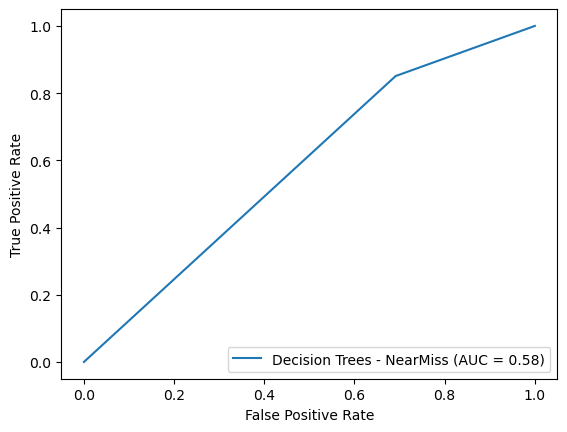

In [60]:
plot_roc(y_test, dectrees_ns_pred, "Decision Trees - NearMiss")

#### Support Vector Machine

In [23]:
# Define the pipeline
pipe = Pipeline([ ('clf',LinearSVC())]) 
# Train the pipeline
pipe.fit(X_ns_train, y_ns_train)

C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\kyria\anaconda3\envs\liu-text-mining\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('clf', LinearSVC())])

In [24]:
svm_ns_pred = pipe.predict(X_test)
print(classification_report(y_test, svm_ns_pred))

              precision    recall  f1-score   support

           0       0.98      0.33      0.49      3395
           1       0.06      0.88      0.12       181

    accuracy                           0.35      3576
   macro avg       0.52      0.60      0.31      3576
weighted avg       0.93      0.35      0.47      3576



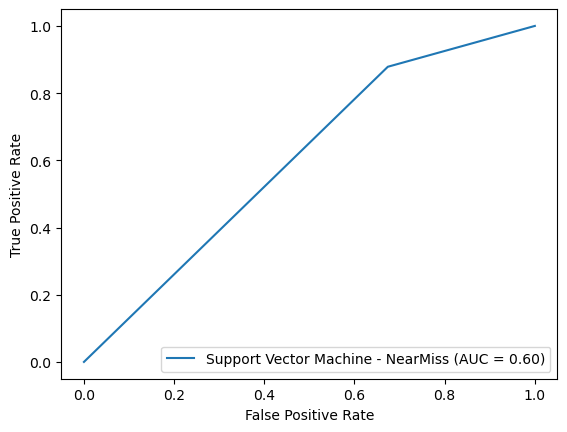

In [25]:
plot_roc(y_test, svm_ns_pred, "Support Vector Machine - NearMiss")